# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [11]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [9]:
functions = il.reload(functions)
month = 'dec' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years_tot = list(range(2000, 2024))
else:
    years_tot = list(range(2000, 2025))
    
for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = f'{scratch}Qingyu_Cesar_EIA/' + month + '_data/' + str(year) + '_' + month + '_' + phase + '/'
    files = os.listdir(path)
    files = [path + i for i in files]

    for f in files:
        if f[-4:] != '.txt':
            files.remove(f)
            
    print(len(files))
    
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)

    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    print('1')
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    grnd_tec0 = functions.kp_index_filtering(grnd_tec, kp)
    print('2')

    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(28) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    pool.close()
    pool.join()
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    t_total = dt.datetime.now() - t_start
    print(t_total)
    

    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/{str(year)}_{month}_{phase}.csv', index=False)


  0%|                                                                                                            | 0/23 [00:00<?, ?it/s]

2001
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:04:27.064427


  4%|████▏                                                                                            | 1/23 [05:23<1:58:34, 323.38s/it]

2002
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:05:54.764775


  9%|████████▍                                                                                        | 2/23 [12:24<2:13:23, 381.10s/it]

2003
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:03:57.082185


 13%|████████████▋                                                                                    | 3/23 [17:29<1:55:24, 346.22s/it]

2004
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:07:44.265709


 17%|████████████████▊                                                                                | 4/23 [26:38<2:15:00, 426.36s/it]

2005
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:06:24.024056


 22%|█████████████████████                                                                            | 5/23 [34:28<2:12:37, 442.06s/it]

2006
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:07:36.071705


 26%|█████████████████████████▎                                                                       | 6/23 [43:35<2:15:21, 477.73s/it]

2007
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:11:03.407486


 30%|█████████████████████████████▌                                                                   | 7/23 [56:25<2:32:53, 573.34s/it]

2008
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:12:14.436000


 35%|█████████████████████████████████                                                              | 8/23 [1:10:28<2:44:45, 659.00s/it]

2009
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:12:39.234045


 39%|█████████████████████████████████████▏                                                         | 9/23 [1:24:58<2:49:11, 725.07s/it]

2010
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:13:51.663485


 43%|████████████████████████████████████████▊                                                     | 10/23 [1:40:59<2:52:53, 797.93s/it]

2011
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:14:03.743951


 48%|████████████████████████████████████████████▉                                                 | 11/23 [1:57:06<2:49:56, 849.70s/it]

2012
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:24:36.112223


 52%|████████████████████████████████████████████████▌                                            | 12/23 [2:25:29<3:23:21, 1109.25s/it]

2013
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:24:25.941731


 57%|████████████████████████████████████████████████████▌                                        | 13/23 [2:53:30<3:33:43, 1282.40s/it]

2014
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:25:09.558284


 61%|████████████████████████████████████████████████████████▌                                    | 14/23 [3:22:42<3:33:37, 1424.12s/it]

2015
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:13:52.554326


 65%|████████████████████████████████████████████████████████████▋                                | 15/23 [3:39:38<2:53:29, 1301.22s/it]

2016
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:18:38.243086


 70%|████████████████████████████████████████████████████████████████▋                            | 16/23 [4:01:39<2:32:29, 1307.11s/it]

2017
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:25:41.302333


 74%|████████████████████████████████████████████████████████████████████▋                        | 17/23 [4:31:13<2:24:45, 1447.61s/it]

2018
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:26:59.455064


 78%|████████████████████████████████████████████████████████████████████████▊                    | 18/23 [5:02:11<2:10:54, 1570.97s/it]

2019
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:34:40.000589


 83%|████████████████████████████████████████████████████████████████████████████▊                | 19/23 [5:41:45<2:00:47, 1811.98s/it]

2020
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:36:02.480750


 87%|████████████████████████████████████████████████████████████████████████████████▊            | 20/23 [6:22:34<1:40:10, 2003.43s/it]

2021
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:33:40.044301


 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 21/23 [7:00:48<1:09:40, 2090.42s/it]

2022
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:20:45.180059


 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 22/23 [7:25:53<31:54, 1914.88s/it]

2023
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:32:41.863806


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [8:03:41<00:00, 1261.82s/it]


# F10.7 Comparison for March 2023 and 2024

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [ ]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
functions = il.reload(functions)
f107_years = [2023, 2024]
month = 'march'

path = f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/f107_{month}_'

columns = ['Year', 'DOY', 'Hour', 'f10_7']
f107 = pd.DataFrame(columns = columns)

for y in f107_years:
    file = f'{path}{str(y)}.txt'
    df_f107 = pd.read_csv(file, sep=r'\s+')
    print(y, 'year -> Mean =', sum(df_f107.f10_7)/len(df_f107.f10_7), 'and Median =', np.median(df_f107.f10_7))
print('\nBoth mean and median of F10.7 index during ' + month + ' equinox for 2023 is higher than 2024.')

2023 year -> Mean = 150.87441860465202 and Median = 148.1
2024 year -> Mean = 146.01395348837212 and Median = 137.6

Both mean and median of F10.7 index during march equinox for 2023 is higher than 2024.


# Reading Data Directly From Saved Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
import datetime as dt
from scipy.signal import savgol_filter
import statistics


In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

  0%|                                                                                                            | 0/24 [00:00<?, ?it/s]

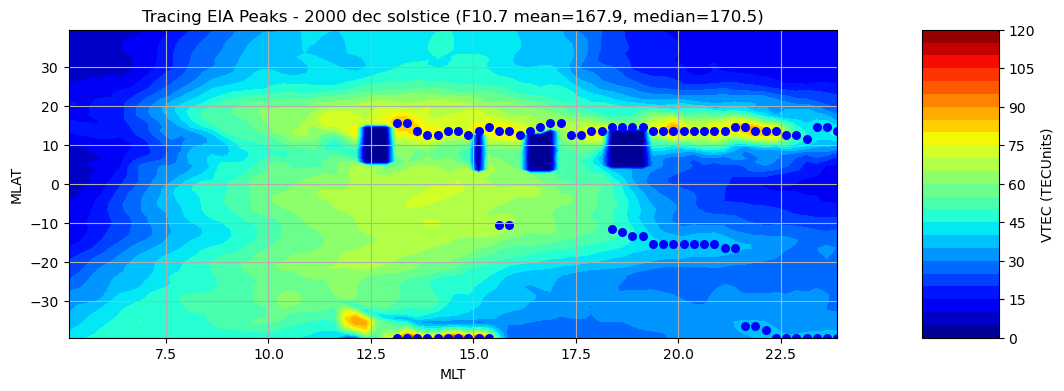

  4%|████▏                                                                                               | 1/24 [00:02<01:06,  2.89s/it]

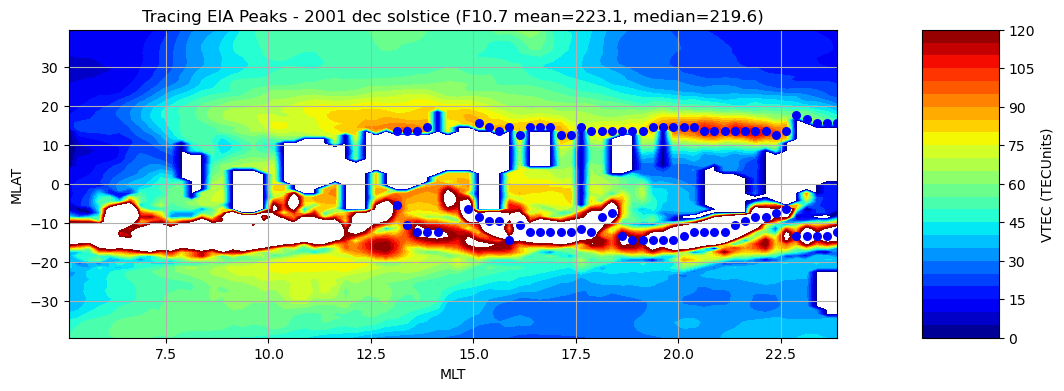

  8%|████████▎                                                                                           | 2/24 [00:04<00:47,  2.17s/it]

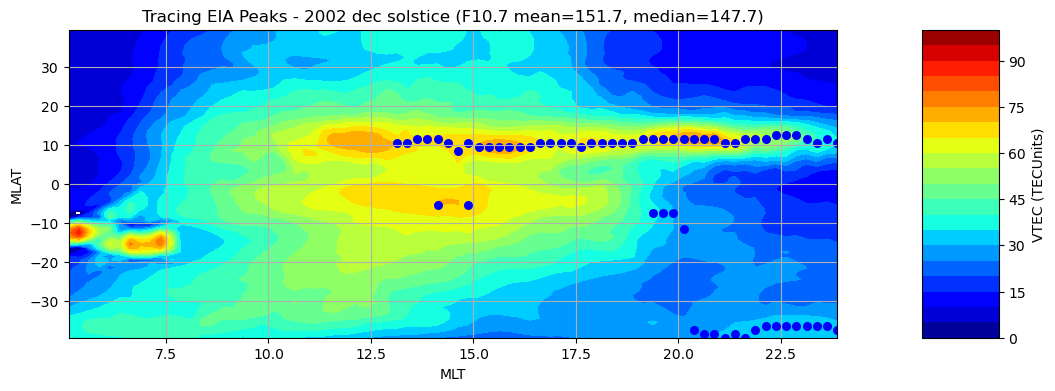

 12%|████████████▌                                                                                       | 3/24 [00:06<00:48,  2.29s/it]

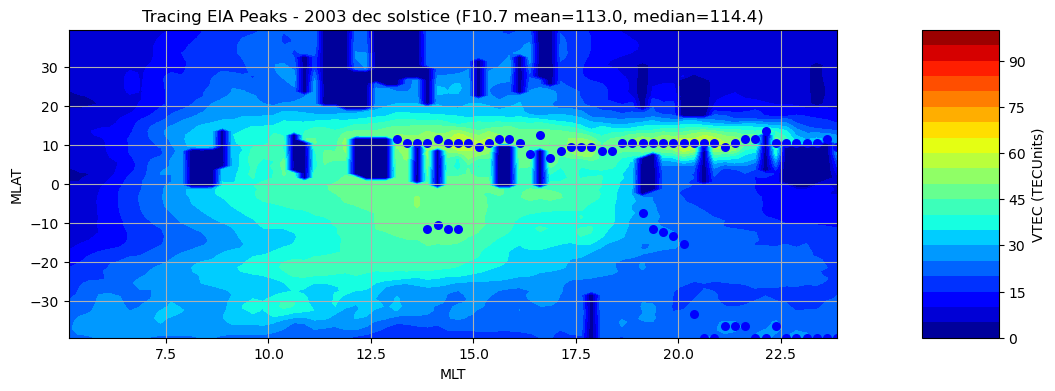

 17%|████████████████▋                                                                                   | 4/24 [00:08<00:40,  2.03s/it]

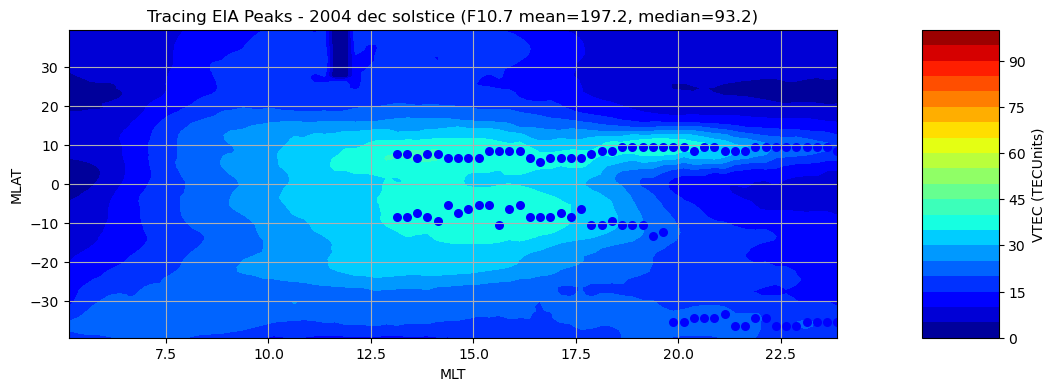

 21%|████████████████████▊                                                                               | 5/24 [00:11<00:45,  2.38s/it]

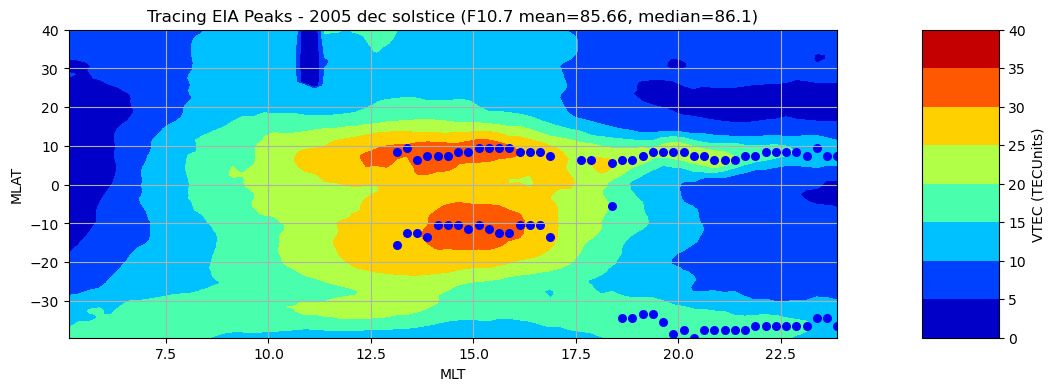

 25%|█████████████████████████                                                                           | 6/24 [00:14<00:45,  2.55s/it]

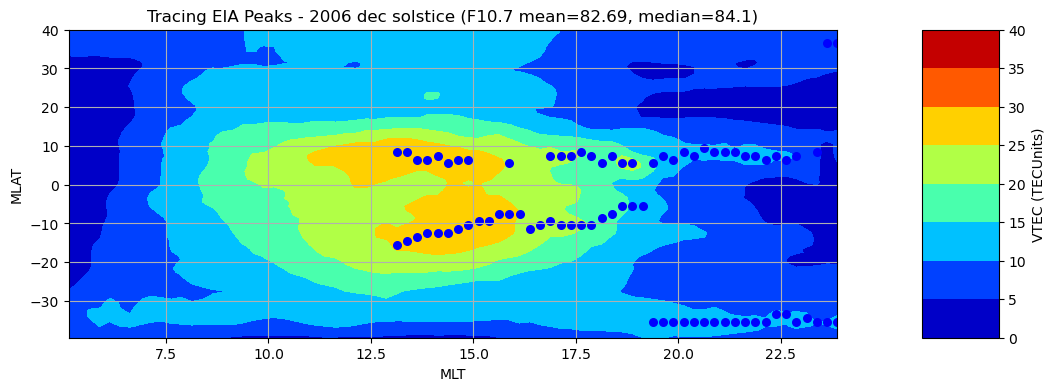

 29%|█████████████████████████████▏                                                                      | 7/24 [00:17<00:46,  2.76s/it]

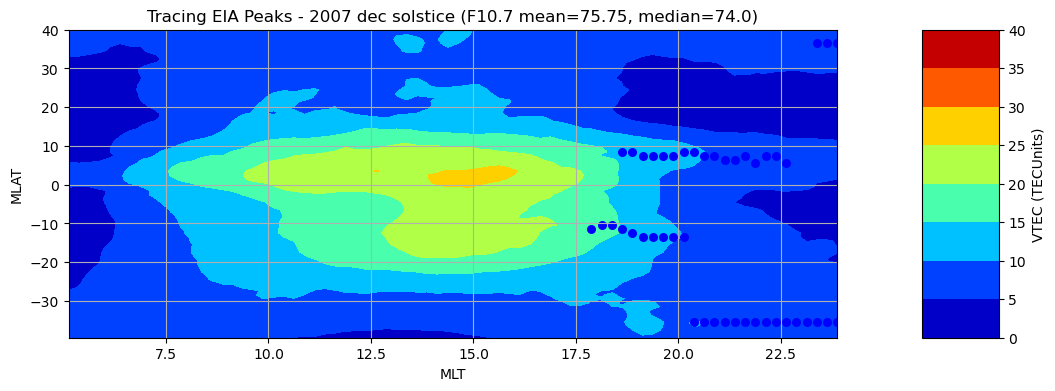

 33%|█████████████████████████████████▎                                                                  | 8/24 [00:21<00:51,  3.19s/it]

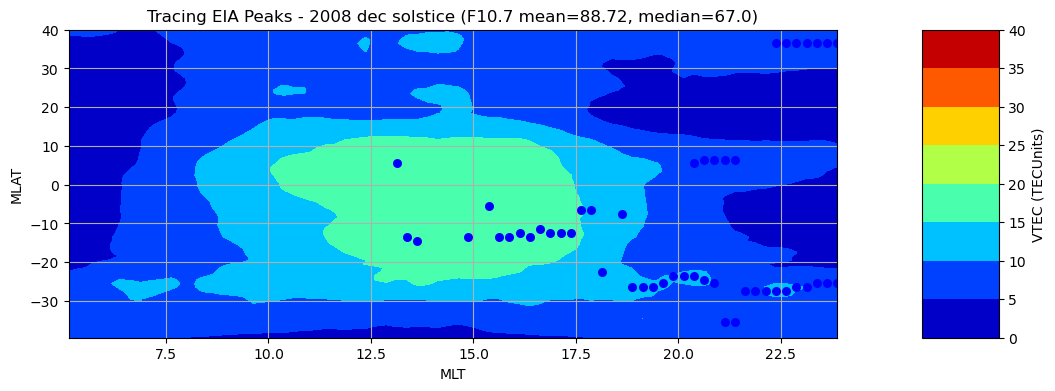

 38%|█████████████████████████████████████▌                                                              | 9/24 [00:26<00:56,  3.77s/it]

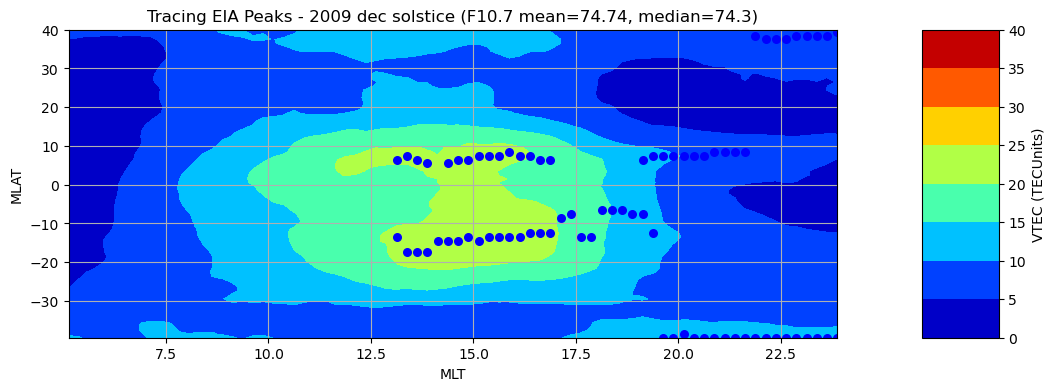

 42%|█████████████████████████████████████████▎                                                         | 10/24 [00:31<00:58,  4.19s/it]

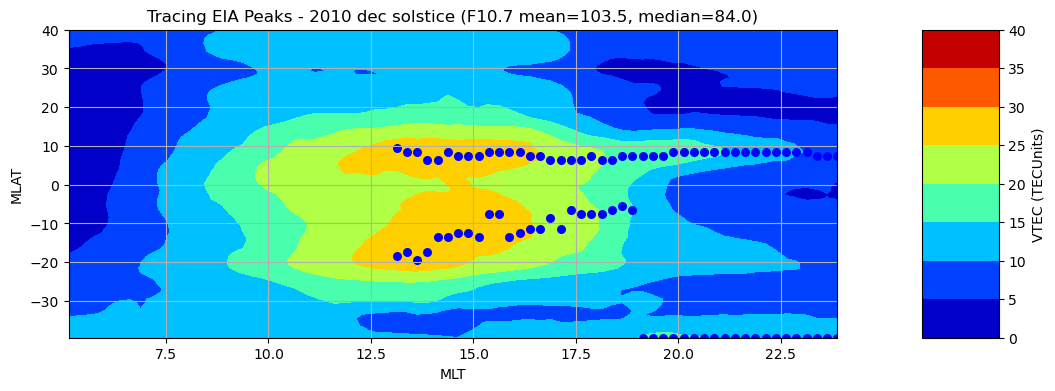

 46%|█████████████████████████████████████████████▍                                                     | 11/24 [00:39<01:06,  5.10s/it]

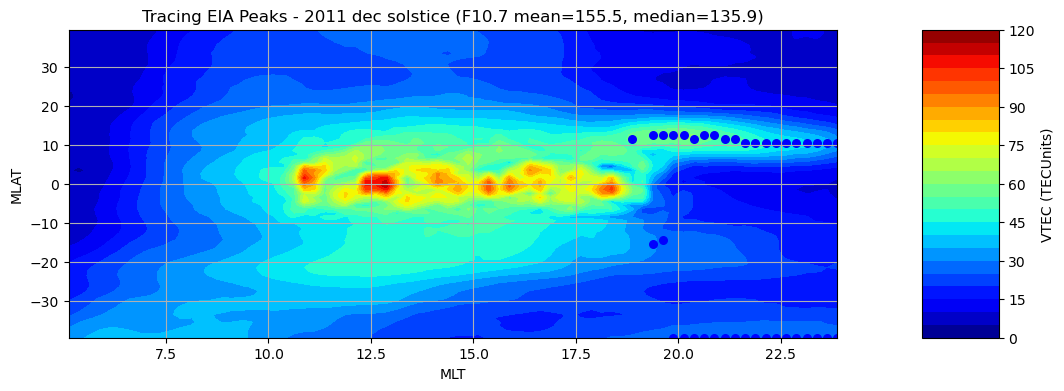

 50%|█████████████████████████████████████████████████▌                                                 | 12/24 [00:46<01:09,  5.80s/it]

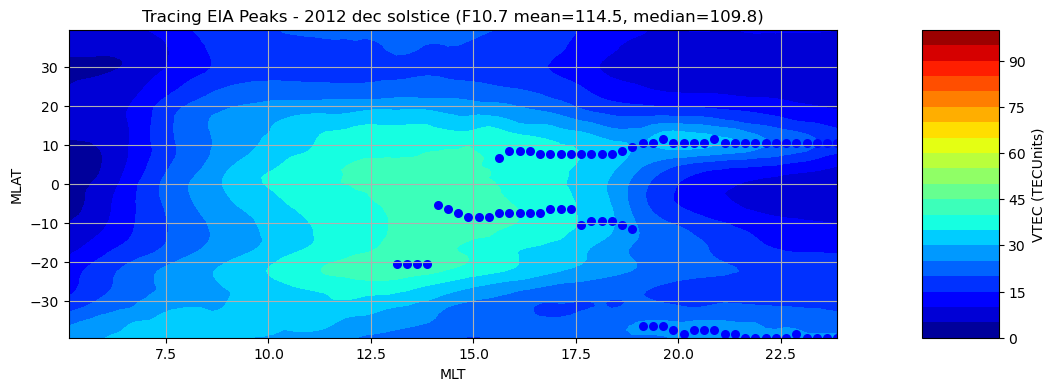

 54%|█████████████████████████████████████████████████████▌                                             | 13/24 [01:00<01:31,  8.31s/it]

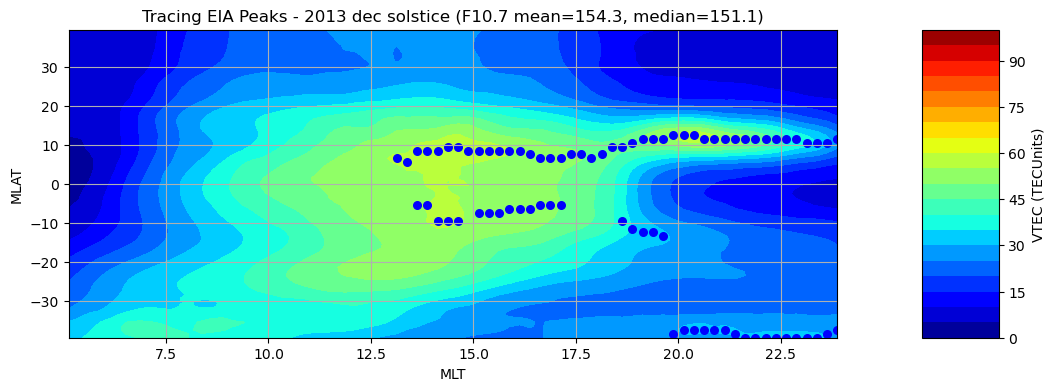

 58%|█████████████████████████████████████████████████████████▊                                         | 14/24 [01:14<01:40, 10.04s/it]

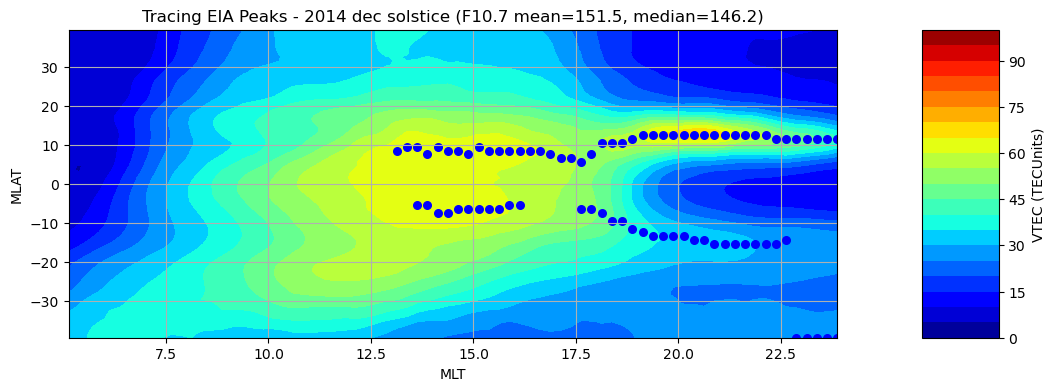

 62%|█████████████████████████████████████████████████████████████▉                                     | 15/24 [01:29<01:44, 11.59s/it]

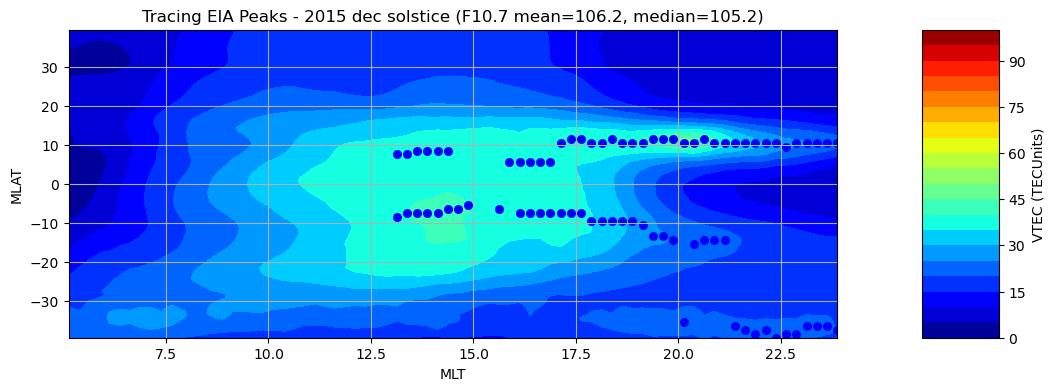

 67%|██████████████████████████████████████████████████████████████████                                 | 16/24 [01:37<01:24, 10.50s/it]

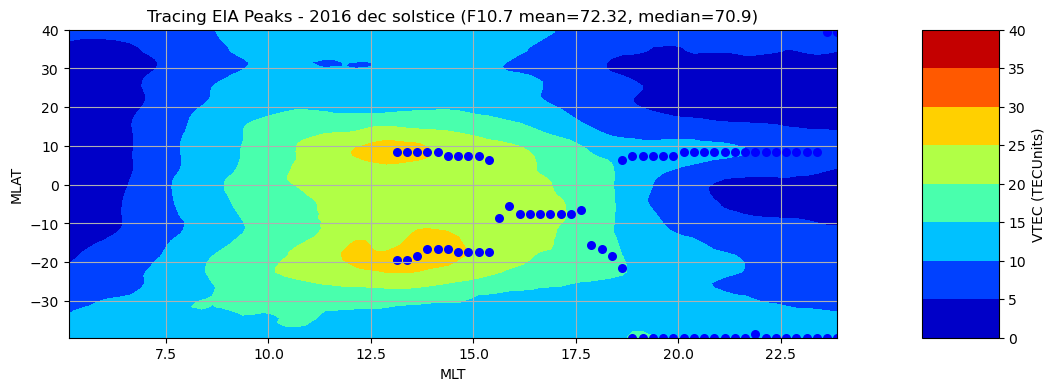

 71%|██████████████████████████████████████████████████████████████████████▏                            | 17/24 [01:47<01:12, 10.38s/it]

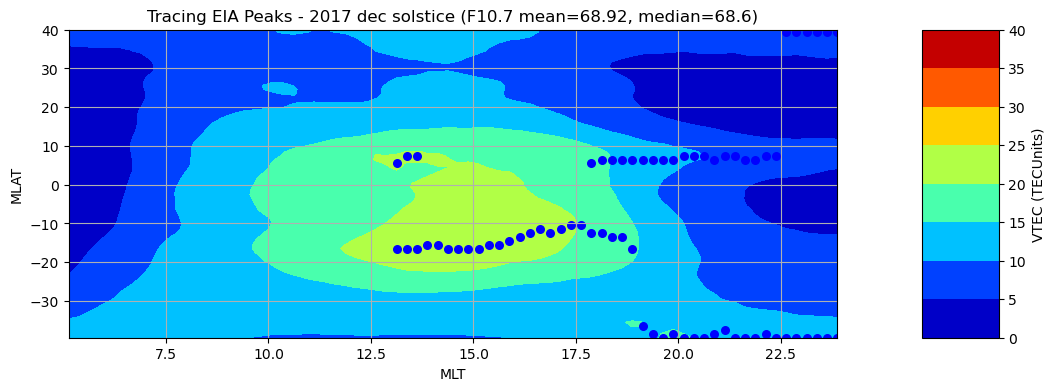

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 18/24 [02:01<01:07, 11.21s/it]

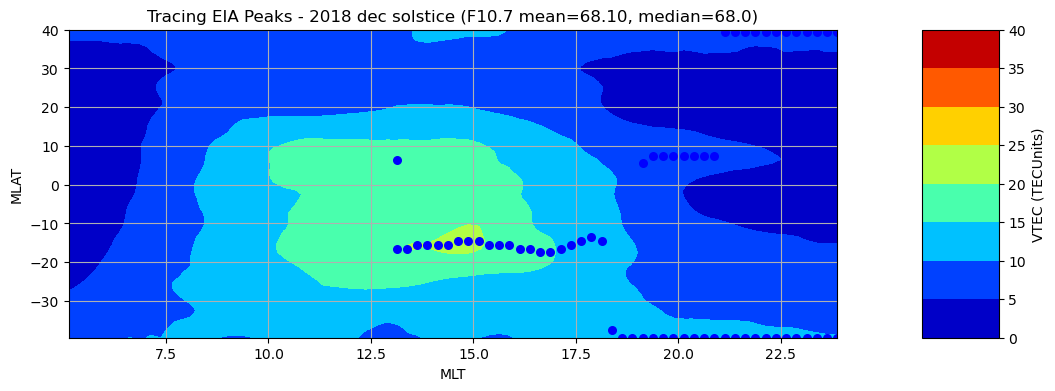

 79%|██████████████████████████████████████████████████████████████████████████████▍                    | 19/24 [02:14<00:59, 11.95s/it]

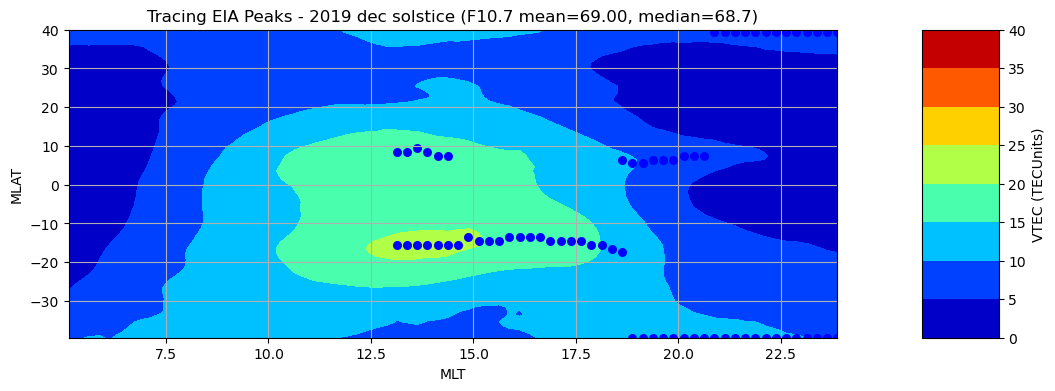

 83%|██████████████████████████████████████████████████████████████████████████████████▌                | 20/24 [02:32<00:54, 13.59s/it]

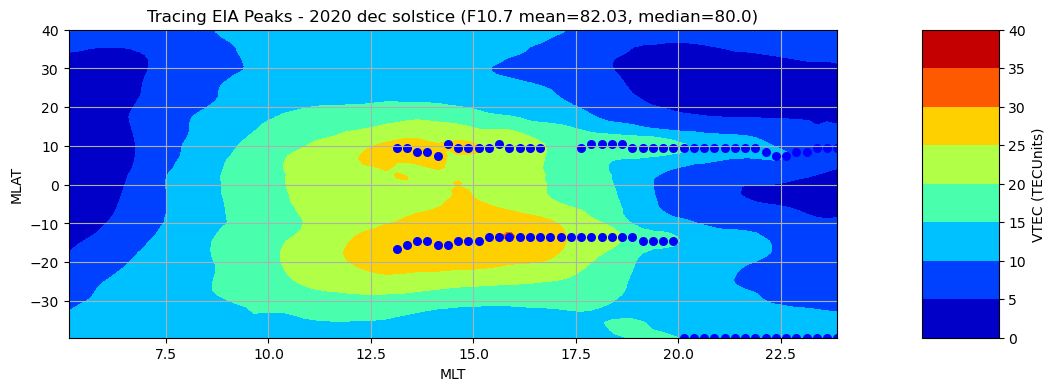

 88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 21/24 [02:51<00:46, 15.38s/it]

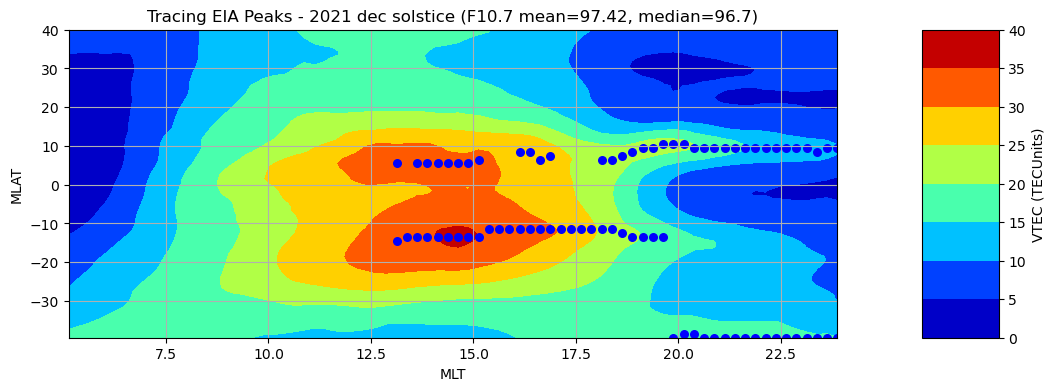

 92%|██████████████████████████████████████████████████████████████████████████████████████████▊        | 22/24 [03:09<00:32, 16.08s/it]

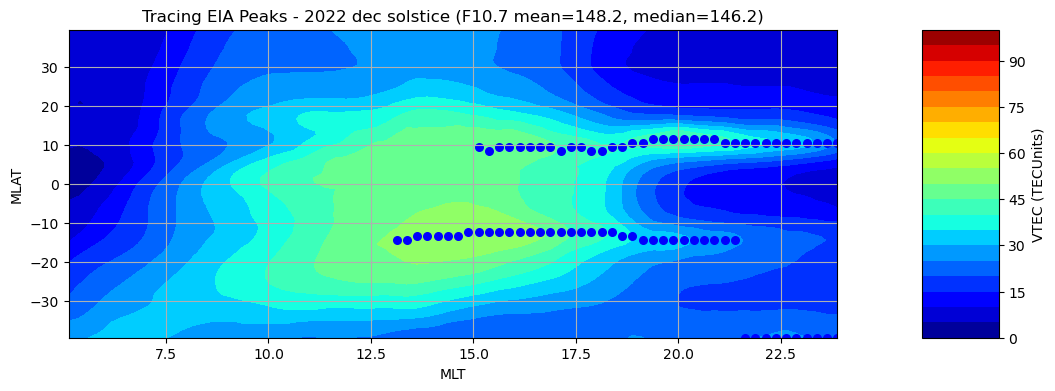

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▉    | 23/24 [03:21<00:14, 14.84s/it]

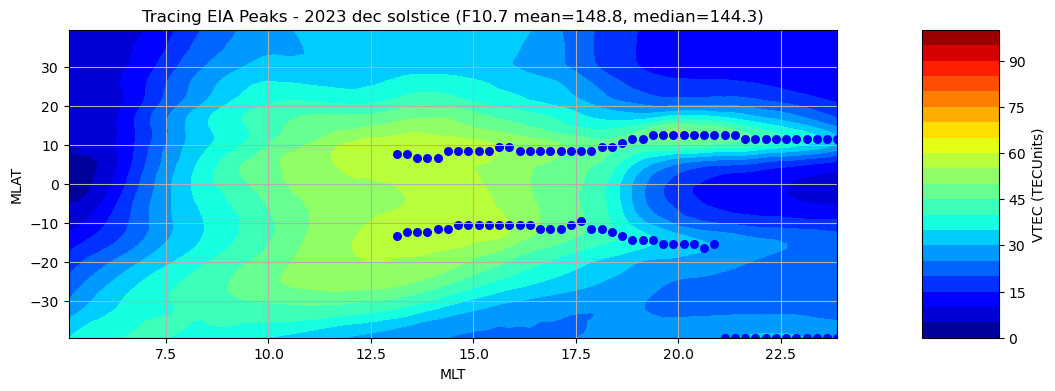

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:38<00:00,  9.12s/it]


In [3]:
month = 'dec'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years = list(range(2000, 2024))
else:
    years = list(range(2000, 2025))


for year in tqdm(years):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv')


    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))
    
    # Create a new DataFrame with the bins
    grnd_tec2['MLAT_b'] = bins_mlat
    grnd_tec2['MLT_b'] = bins_mlt
    
    # Group by the bins (MLAT_b (primary) and MLT_b (secondary)) and calculate the average of TEC
    result = grnd_tec2.groupby(['MLT_b', 'MLAT_b'], observed=False)['TEC'].mean().reset_index()
    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
    result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
    result['MLAT_b'] = result['MLAT_b'].astype(float)
    result['MLT_b'] = result['MLT_b'].astype(float)


    result = result[result.MLT_b >= 5].reset_index(drop=True)
    
    
    filtered = []
    for t in result['MLT_b'].unique():
        result_f = result[result['MLT_b'] == t].reset_index(drop=True)
        fit = savgol_filter(np.array(result_f.TEC), 10, 2)
        filtered.extend(fit)
    result['TEC'] = filtered
    result = result.groupby(['MLAT_b', 'MLT_b'], observed=False).sum().reset_index()
    
    
    # Identifying NH and SH peaks
    result_t = result[result.MLT_b >= 13].reset_index(drop=True)
    result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
    result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)
    result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    # Dropping the cases where the SH peak is not prominent and maxima appears to come at equator
    result_n.loc[result_n['MLAT_b'] < 5, 'TEC'] = np.nan
    result_s.loc[result_s['MLAT_b'] > -5, 'TEC'] = np.nan
    #print(result_s)
    
    i = 100*2*(result_n.TEC - result_s.TEC)/(result_n.TEC + result_s.TEC)
    result_ind = pd.DataFrame({'mlat_n': result_n.MLAT_b, 'tec_n': result_n.TEC, 'mlat_s': result_s.MLAT_b, 'tec_s': result_s.TEC, 'mlt': result_n.MLT_b, 'asy': i})
    result_ind.to_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(year)}_{month}.csv', index=False)

    X, Y = np.meshgrid(result.MLT_b.unique(), result.MLAT_b.unique())
    Z = result.TEC.values.reshape(X.shape)
    if np.max(Z) <= 40:
        contour_levels = list(range(0, 41, 5))
    elif np.max(Z) <= 100:
        contour_levels = list(range(0, 101, 5))
    elif np.max(Z) <= 120:
        contour_levels = list(range(0, 121, 5))
    elif np.max(Z) <= 150:
        contour_levels = list(range(0, 151, 5))

    # Creating new dataframe to remove rows where TEC= NaN
    result_n = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_n': result_ind.mlat_n, 'tec_n': result_ind.tec_n})
    result_n = result_n.dropna(subset='tec_n')
    result_s = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_s': result_ind.mlat_s, 'tec_s': result_ind.tec_s})
    result_s = result_s.dropna(subset='tec_s')

    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    f10_mean = sum(kp['F10.7'])/len(kp['F10.7'])
    f10_med = statistics.median(kp['F10.7'])
    
    
    fig = plt.figure(figsize=(12,4))
    specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
    ax = []
    ax.append(fig.add_subplot(specs[0, 0]))
    c = ax[0].contourf(X, Y, Z, levels=contour_levels, cmap = 'jet')
    ax[0].scatter(result_n.mlt, result_n.mlat_n, c='b', s=30)
    ax[0].scatter(result_s.mlt, result_s.mlat_s, c='b', s=30)
    ax[0].set_title(f'Tracing EIA Peaks - {str(year)} {month} {phase} (F10.7 mean={str(f10_mean)[:5]}, median={str(f10_med)})')
    ax[0].set_ylabel('MLAT')
    ax[0].set_xlabel('MLT')
    ax[0].grid(True)

    # Set ylim conditionally
    if np.max(Z) <= 40:
        ax[0].set_ylim(top=40)
    
    cbar_ax = fig.add_subplot(specs[0,1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/eia_peaks_{month}_{str(year)}.jpg')
    plt.show()




# Comparing Asymmetry Index

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [30]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [31]:
month = 'dec' # 'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years = list(range(2007, 2010)) + list(range(2018, 2021)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2024))
else:
    years = list(range(2007, 2010)) + list(range(2018, 2021)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2025))


asy_ind = []

for y in years:
    f = pd.read_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(y)}_{month}.csv')
    asy_ind.append(f)

0it [00:00, ?it/s]/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/4219899893.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/4219899893.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/4219899893.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be

       mlt        asy
17  13.125  -1.780538
18  13.875  -4.642104
19  14.625  -9.761287
20  15.375  -9.375044
21  16.125 -11.306814
22  16.875 -14.471683
24  18.375  -0.697729
25  19.125   3.774256
26  19.875   0.689877
27  20.625 -14.919413
28  21.375 -22.385875
29  22.125 -31.580165
30  22.875 -38.124739
31  23.625 -25.852879
       mlt        asy
17  13.125 -11.799586
18  13.875 -14.303627
19  14.625 -16.075426
20  15.375 -18.991048
21  16.125 -26.436207
22  16.875 -32.403341
23  17.625 -21.996008
24  18.375 -22.036743
25  19.125 -18.982220
26  19.875 -26.321892
27  20.625 -36.944890
28  21.375 -41.153091
29  22.125 -40.176988
30  22.875 -37.454358
31  23.625 -35.408605
       mlt        asy
17  13.125  -8.569259
18  13.875 -15.175247
19  14.625 -21.627501
20  15.375 -38.291128
21  16.125 -38.470715
22  16.875 -85.020242
23  17.625 -83.085306
24  18.375 -24.071606
25  19.125   5.464647
26  19.875  24.885062
27  20.625  15.202645
28  21.375  15.029523
29  22.125  28.938163
30  22.875

/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/4219899893.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/4219899893.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/4219899893.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index(

       mlt        asy
18  13.875   1.094143
19  14.625  -0.533993
20  15.375   0.975582
21  16.125   1.452214
22  16.875   0.151419
23  17.625   1.661176
24  18.375  14.937236
25  19.125  34.870631
26  19.875  48.733426
27  20.625  50.192141
28  21.375  44.264675
29  22.125  33.327508
30  22.875  21.508969
31  23.625   3.204235
       mlt        asy
17  13.125   3.166017
18  13.875   0.616679
19  14.625  -2.047633
20  15.375  -5.956836
21  16.125  -3.651577
22  16.875  -0.553648
23  17.625   2.107931
24  18.375   7.837279
25  19.125  24.086568
26  19.875  38.180279
27  20.625  44.601534
28  21.375  42.617417
29  22.125  33.500532
30  22.875  24.167693
31  23.625   9.844725


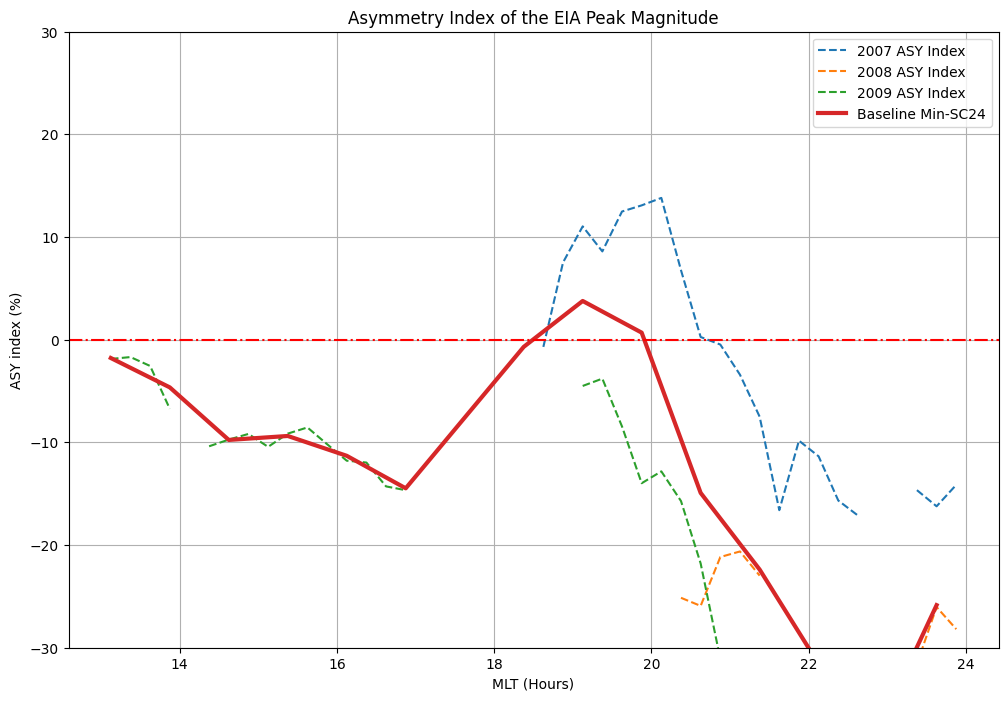

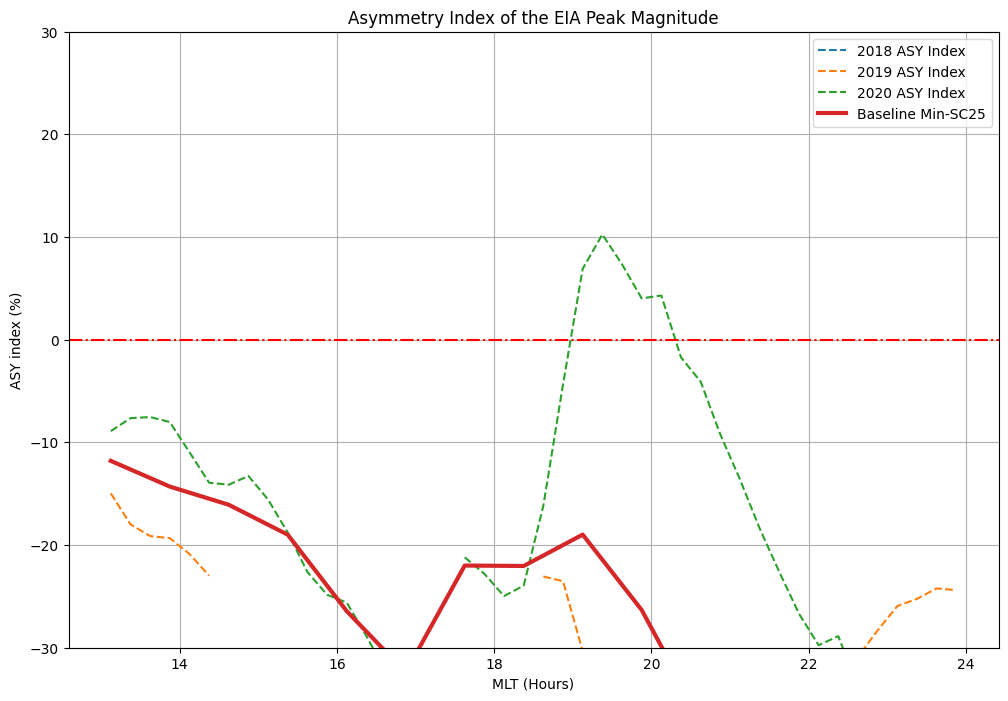

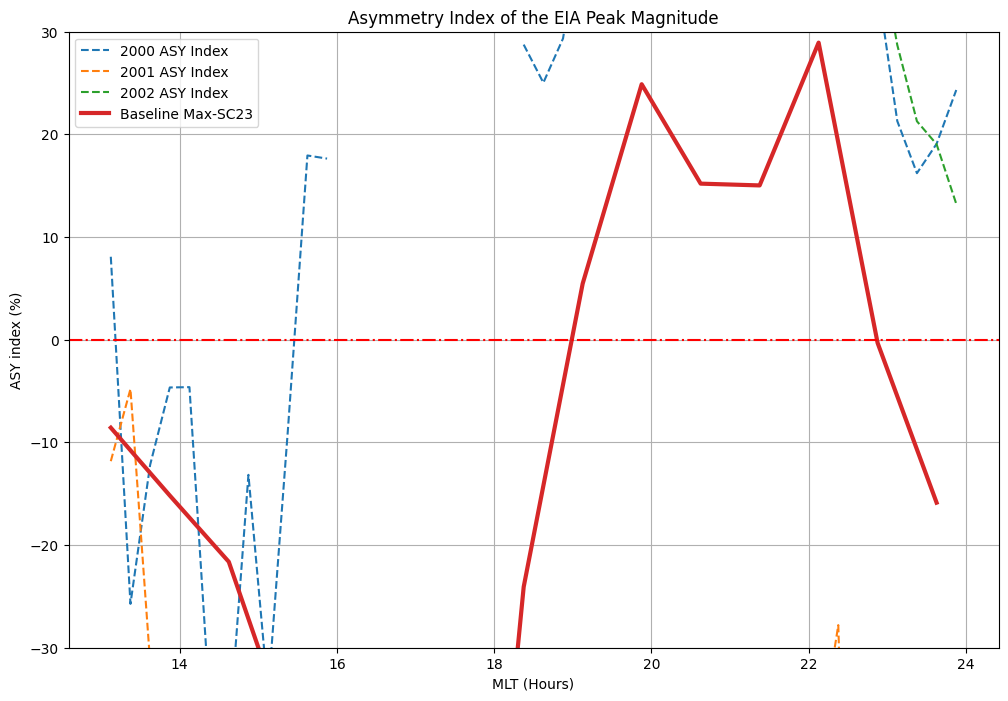

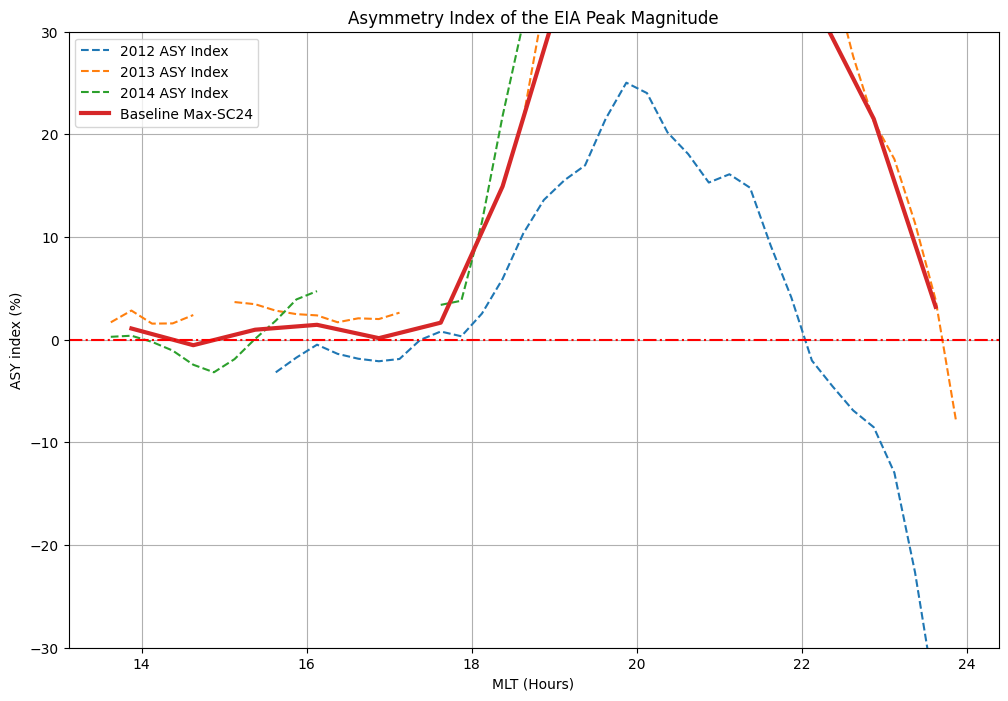

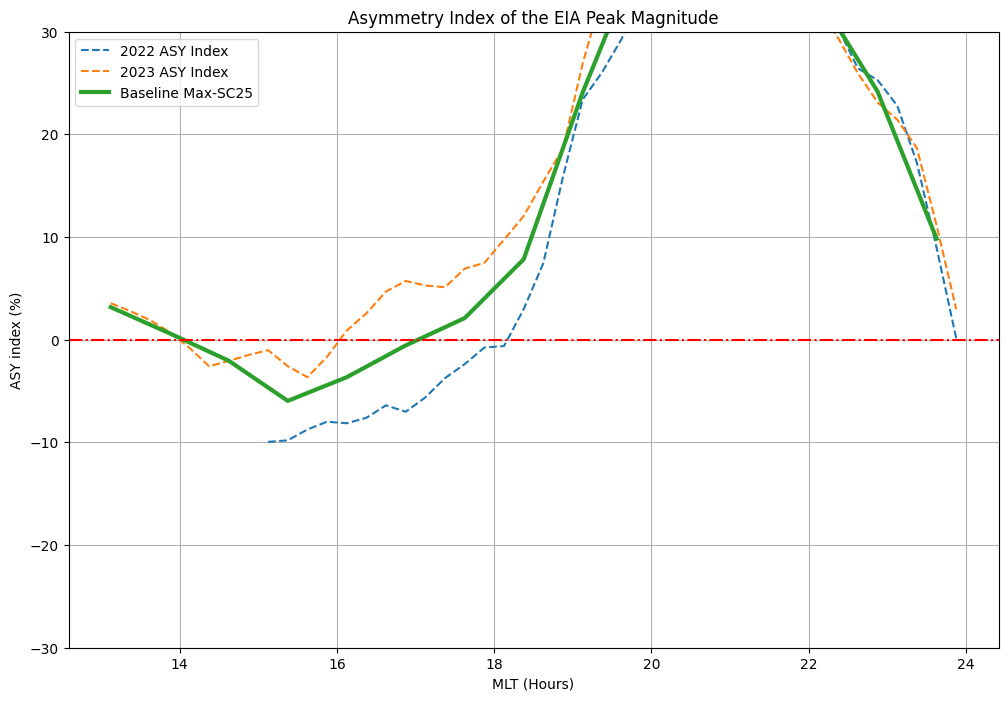

In [32]:
if month == 'sept' or month == 'dec':
    solar_cyc = [[list(range(2007, 2010))], [list(range(2018, 2021))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2024))]]
else:
    solar_cyc = [[list(range(2007, 2010))], [list(range(2018, 2021))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2025))]]


sc = ['Baseline Min-SC24', 'Baseline Min-SC25', 'Baseline Max-SC23', 'Baseline Max-SC24', 'Baseline Max-SC25']

sc_base = []

for s, n in tqdm(zip(solar_cyc, sc)):

    fig = plt.figure(figsize=(12,8))

    for periods in s:
        columns = ['mlt', 'asy']
        baseline = pd.DataFrame(columns=columns)

        for p in periods:
            a = pd.read_csv(f'{work}/Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(p)}_{month}.csv')
            a = a.drop(['mlat_n', 'mlat_s', 'tec_n', 'tec_s'], axis=1)
            #a = a.dropna(subset = 'asy')
            baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
            plt.plot(a.mlt, a.asy, linestyle = '--', label = f'{str(p)} ASY Index')
        
        baseline = baseline.sort_values(by=['mlt'], ascending=[True])
        bins_mlt = pd.cut(baseline['mlt'], bins=pd.interval_range(start=0, end=24, freq=0.75))
        baseline['mlt'] = bins_mlt
        baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
        baseline['mlt'] = baseline['mlt'].apply(lambda x: x.mid)
        baseline['mlt'] = baseline['mlt'].astype(float)
        baseline.dropna(inplace=True)
        plt.plot(baseline.mlt, baseline.asy, label=n, linewidth=3)
        print(baseline)
        break
    
    plt.ylim(-30,30)
    plt.axhline(y=0, color='red', linestyle='-.')
    plt.legend()
    plt.title('Asymmetry Index of the EIA Peak Magnitude')
    plt.ylabel('ASY index (%)')
    plt.xlabel('MLT (Hours)')
    plt.grid(True)
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/{n[-8:]}_{month}.jpg')
    plt.show()
    
    sc_base.append(baseline)


/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/1517522118.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/1517522118.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


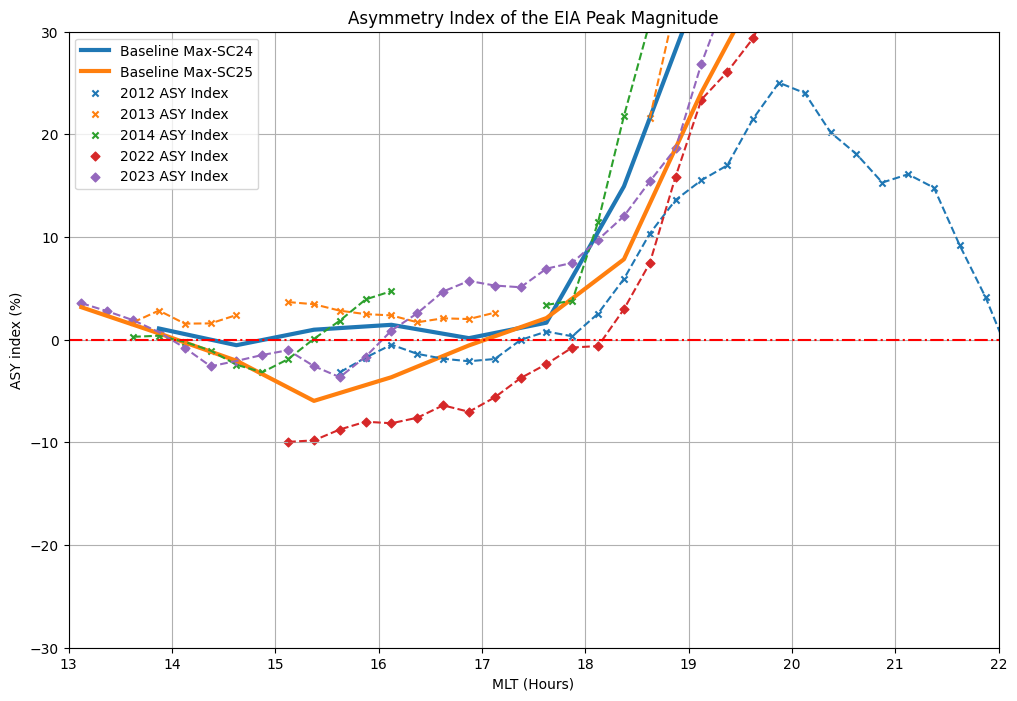

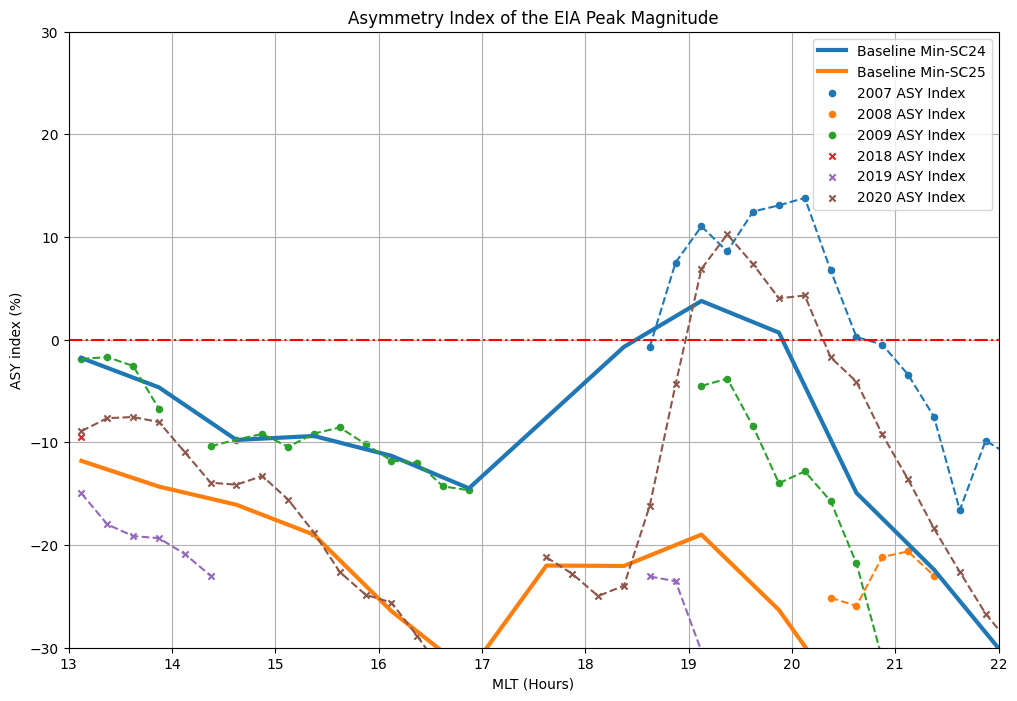

In [33]:
color = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
marker = ['o', 'x', 'D', 's']


# Solar maxima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[3:], sc[3:]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[9:], years[9:]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=f'{str(y)} ASY Index', s=20)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MAX_{month}.jpg')
fig.show()

# Solar minima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[:2], sc[:2]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[:6], years[:6]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=str(y) + ' ASY Index', s=20)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MIN_{month}.jpg')
plt.show()



/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/2053911285.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/0j/cdkpybh91qb3csbzkwm2tc_00000gn/T/ipykernel_30030/2053911285.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


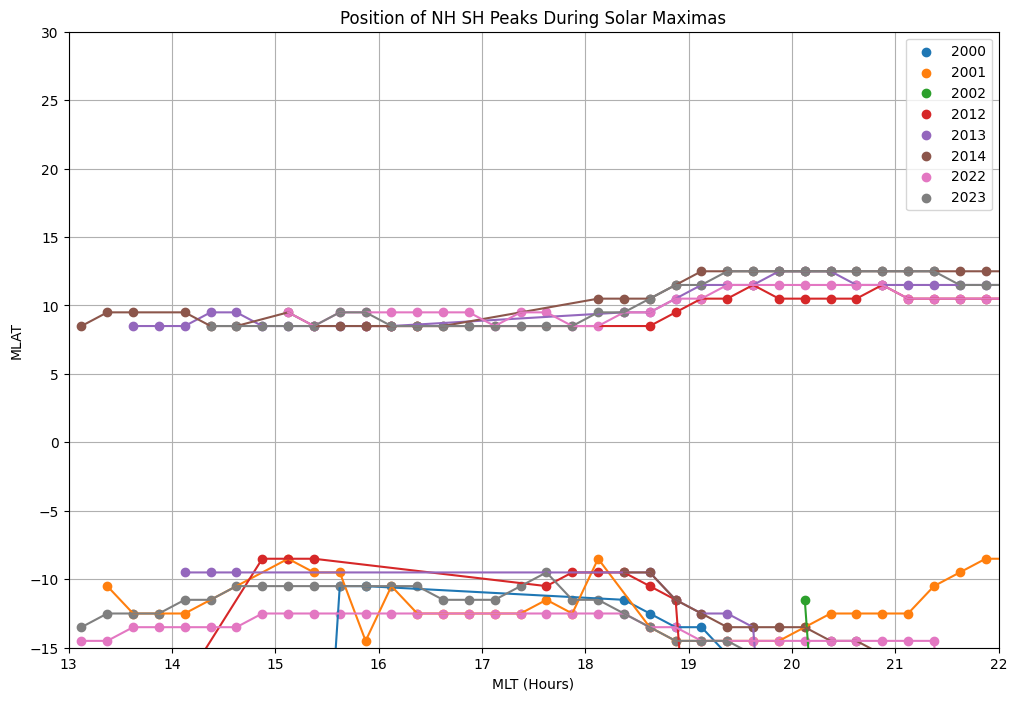

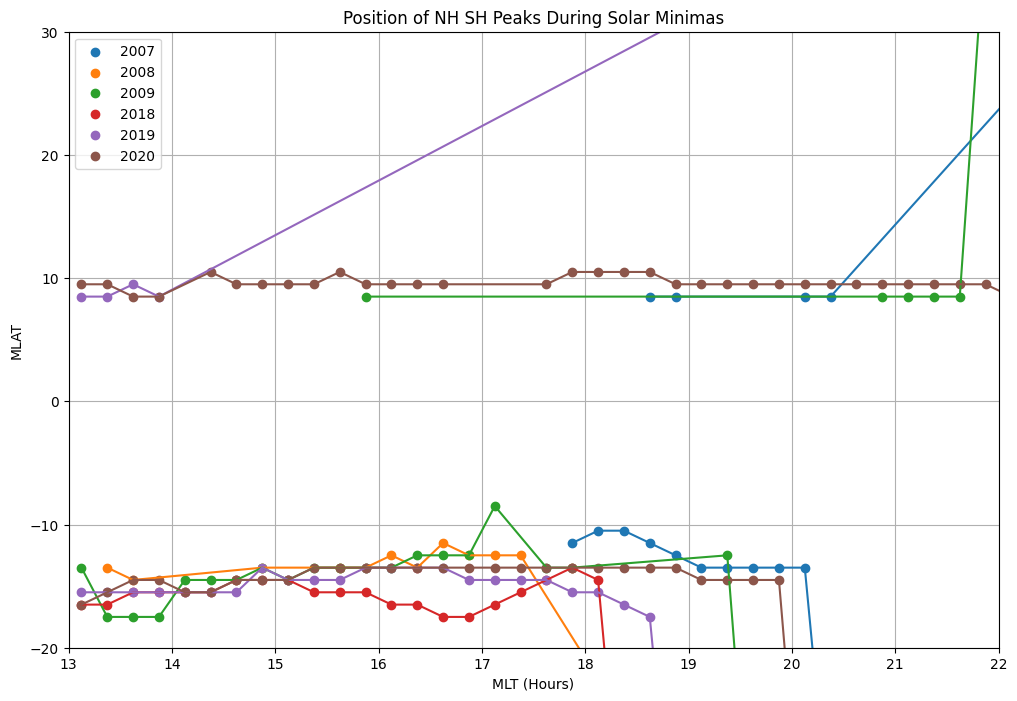

In [34]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Solar Max Peak Locations
n = 0
fig = plt.figure(figsize=(12,8))
for a, y in zip(asy_ind[6:], years[6:]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    plt.scatter(time, mlat, c=color[n], label = str(y))
    plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    n = n+1
    
if month == 'june' or month == 'dec':
    plt.ylim(-15,30)
else:
    plt.ylim(-20,20)
plt.xlim(13,22)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Maximas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MAX_{month}.jpg')
fig.show()


# Solar Min Peak Locations
fig = plt.figure(figsize=(12,8))
n = 0
for a, y in zip(asy_ind[:6], years[:6]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    plt.scatter(time, mlat, c = color[n], label=str(y))
    plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    n = n + 1

if month == 'june' or month == 'dec':
    plt.ylim(-20, 30)
else:
    plt.ylim(-15,15)
plt.xlim(13,22)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Minimas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MIN_{month}.jpg')
plt.show()
